<a href="https://colab.research.google.com/github/yohanesnuwara/MLP-Optimizer-Supply-Chain-Problem/blob/main/Supply_Chain_Logistics_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam, AdamW, Ftrl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('ggplot')

In [ ]:
root = '/content/drive/MyDrive/Hackathons/Shell 2024/Data/'


### 1 - Use the sample_submission as initial condition

In [ ]:
submission_path = 'sample_submission.csv'

submission_df = pd.read_csv(root+submission_path)

submission_df

,Year,ID,Num_Vehicles,Type,Fuel,Distance_bucket,Distance_per_vehicle(km)
0,2023,BEV_S1_2023,3,Buy,NaN,NaN,0.0
1,2023,Diesel_S1_2023,36,Buy,NaN,NaN,0.0
2,2023,LNG_S1_2023,34,Buy,NaN,NaN,0.0
3,2023,BEV_S2_2023,4,Buy,NaN,NaN,0.0
4,2023,Diesel_S2_2023,15,Buy,NaN,NaN,0.0
...,...,...,...,...,...,...,...
1682,2038,BEV_S3_2037,4,Use,Electricity,D3,73000.0
1683,2038,BEV_S3_2038,3,Use,Electricity,D3,73000.0
1684,2038,BEV_S3_2033,3,Use,Electricity,D4,73000.0
1685,2038,BEV_S3_2036,1,Use,Electricity,D4,73000.0


In [ ]:
df_type = submission_df.pivot_table(values='Num_Vehicles', index=['ID', 'Year'], columns='Type', aggfunc=sum)

# Vehicles are sold end of year, so the total vehicles in following year is reduced by the sold vehicles
# so we shift the sell to the next year
df_type['Sell_shifted'] = df_type.groupby(level='ID')['Sell'].shift(1)
df_type = df_type.fillna(0)

# Calculate total feet as buy+use-minus
df_type['Total'] = df_type['Buy'] + df_type['Use'] - df_type['Sell_shifted']

df_type

Type              Buy  Sell  Use  Sell_shifted  Total
ID          Year                                     
BEV_S1_2023 2023  3.0   1.0  3.0           0.0    6.0
            2024  0.0   0.0  2.0           1.0    1.0
            2025  0.0   0.0  2.0           0.0    2.0
            2026  0.0   0.0  2.0           0.0    2.0
            2027  0.0   0.0  2.0           0.0    2.0
...               ...   ...  ...           ...    ...
LNG_S4_2031 2033  0.0   0.0  1.0           0.0    1.0
            2034  0.0   0.0  1.0           0.0    1.0
            2035  0.0   0.0  1.0           0.0    1.0
            2036  0.0   0.0  1.0           0.0    1.0
            2037  0.0   1.0  1.0           0.0    1.0

[502 rows x 5 columns]

### 2 - Merge vehicles, fuels, and vehicles_fuel

Note that the year registered here is the year serie of vehicle (also year of purchase). In operation, we can have a 2023-serie vehicle during 2028 for example, i.e. using existing fleet

In [ ]:
vehicles_fuels_path = 'vehicles_fuels.csv'
fuels_path = 'fuels.csv'
vehicles_path = 'vehicles.csv'


vehicles_fuels_df = pd.read_csv(root+vehicles_fuels_path)
fuels_df = pd.read_csv(root+fuels_path)
vehicles_df = pd.read_csv(root+vehicles_path)


vehicles_df

,ID,Vehicle,Size,Year,Cost ($),Yearly range (km),Distance
0,BEV_S1_2023,BEV,S1,2023,187000,102000,D1
1,BEV_S1_2024,BEV,S1,2024,177650,102000,D1
2,BEV_S1_2025,BEV,S1,2025,168767,102000,D1
3,BEV_S1_2026,BEV,S1,2026,160329,102000,D2
4,BEV_S1_2027,BEV,S1,2027,152312,102000,D2
...,...,...,...,...,...,...,...
187,LNG_S3_2034,LNG,S3,2034,209208,73000,D4
188,LNG_S3_2035,LNG,S3,2035,215484,73000,D4
189,LNG_S3_2036,LNG,S3,2036,221948,73000,D4
190,LNG_S3_2037,LNG,S3,2037,228607,73000,D4


In [ ]:
vehicles_merge_fuel_df = pd.merge(pd.merge(vehicles_fuels_df, fuels_df, on='Fuel'), vehicles_df, on=['ID', 'Year'])

# # Calculate yearly fuel cost as yearly range*consumption*fuel cost
# vehicles_merge_fuel_df['Fuel cost ($)'] = vehicles_merge_fuel_df['Consumption (unit_fuel/km)'] * vehicles_merge_fuel_df['Yearly range (km)'] * vehicles_merge_fuel_df['Cost ($/unit_fuel)']

# # Calculate yearly emission as yearly range*consumption*emission
# vehicles_merge_fuel_df['Emission (CO2)'] = vehicles_merge_fuel_df['Consumption (unit_fuel/km)'] * vehicles_merge_fuel_df['Yearly range (km)'] * vehicles_merge_fuel_df['Emissions (CO2/unit_fuel)']

# vehicles_merge_fuel_df['Distance_value'] = [i[-1] for i in vehicles_merge_fuel_df['Distance'].values]

vehicles_merge_fuel_df

,ID,Fuel,Consumption (unit_fuel/km),Year,Emissions (CO2/unit_fuel),Cost ($/unit_fuel),Cost Uncertainty (±%),Vehicle,Size,Cost ($),Yearly range (km),Distance
0,BEV_S1_2023,Electricity,0.893043,2023,0.000000,0.191791,0,BEV,S1,187000,102000,D1
1,BEV_S1_2024,Electricity,0.893043,2024,0.000000,0.184113,2,BEV,S1,177650,102000,D1
2,BEV_S1_2025,Electricity,0.893043,2025,0.000000,0.176742,4,BEV,S1,168767,102000,D1
3,BEV_S1_2026,Electricity,0.893043,2026,0.000000,0.169666,6,BEV,S1,160329,102000,D2
4,BEV_S1_2027,Electricity,0.868161,2027,0.000000,0.162873,8,BEV,S1,152312,102000,D2
...,...,...,...,...,...,...,...,...,...,...,...,...
315,LNG_S3_2036,BioLNG,0.155192,2036,0.378439,1.008030,26,LNG,S3,221948,73000,D4
316,LNG_S3_2037,LNG,0.153945,2037,2.486188,0.931944,28,LNG,S3,228607,73000,D4
317,LNG_S3_2037,BioLNG,0.155192,2037,0.378439,1.002141,28,LNG,S3,228607,73000,D4
318,LNG_S3_2038,LNG,0.153945,2038,2.486188,0.926499,30,LNG,S3,235465,73000,D4


### 3 - Cost structure

In [ ]:
profile_path = 'cost_profiles.csv'

profile_df = pd.read_csv(root+profile_path)

profile_df

,End of Year,Resale Value %,Insurance Cost %,Maintenance Cost %
0,1,90,5,1
1,2,80,6,3
2,3,70,7,5
3,4,60,8,7
4,5,50,9,9
5,6,40,10,11
6,7,30,11,13
7,8,30,12,15
8,9,30,13,17
9,10,30,14,19


### 4 - Demand data

In [ ]:
vehicles_merge_fuel_df

,ID,Fuel,Consumption (unit_fuel/km),Year,Emissions (CO2/unit_fuel),Cost ($/unit_fuel),Cost Uncertainty (±%),Vehicle,Size,Cost ($),Yearly range (km),Distance
0,BEV_S1_2023,Electricity,0.893043,2023,0.000000,0.191791,0,BEV,S1,187000,102000,D1
1,BEV_S1_2024,Electricity,0.893043,2024,0.000000,0.184113,2,BEV,S1,177650,102000,D1
2,BEV_S1_2025,Electricity,0.893043,2025,0.000000,0.176742,4,BEV,S1,168767,102000,D1
3,BEV_S1_2026,Electricity,0.893043,2026,0.000000,0.169666,6,BEV,S1,160329,102000,D2
4,BEV_S1_2027,Electricity,0.868161,2027,0.000000,0.162873,8,BEV,S1,152312,102000,D2
...,...,...,...,...,...,...,...,...,...,...,...,...
315,LNG_S3_2036,BioLNG,0.155192,2036,0.378439,1.008030,26,LNG,S3,221948,73000,D4
316,LNG_S3_2037,LNG,0.153945,2037,2.486188,0.931944,28,LNG,S3,228607,73000,D4
317,LNG_S3_2037,BioLNG,0.155192,2037,0.378439,1.002141,28,LNG,S3,228607,73000,D4
318,LNG_S3_2038,LNG,0.153945,2038,2.486188,0.926499,30,LNG,S3,235465,73000,D4


In [ ]:
demand_path = 'demand.csv'

demand_df = pd.read_csv(root+demand_path)

demand_df

,Year,Size,Distance,Demand (km)
0,2023,S1,D1,869181
1,2023,S1,D2,2597094
2,2023,S1,D3,3292011
3,2023,S1,D4,414315
4,2023,S2,D1,995694
...,...,...,...,...
251,2038,S4,D4,2446
252,2038,S3,D1,3229278
253,2038,S3,D2,3297618
254,2038,S3,D3,1448550


### 5 - Cost function

This function produces input variables to calculate cost function

In [ ]:
def inputCost(input_df, vehicles_merge_fuel_df, demand_df):
    # 1 - Fuel cost
    vehicles_merge_fuel_df['Type'] = 'Use'
    merge_with_use_df = pd.merge(input_df, vehicles_merge_fuel_df,
                        on=['ID', 'Fuel', 'Type'],
                        how='left').rename(columns={'Year_x': 'Year'})
    merge_with_use_df = merge_with_use_df[['Year', 'ID', 'Num_Vehicles', 'Type', 'Fuel',
                         'Distance_bucket', 'Distance_per_vehicle(km)',
                         'Consumption (unit_fuel/km)', 'Cost ($/unit_fuel)',
                         'Yearly range (km)', 'Size']].fillna(0)

    # 2 - purchase cost
    vehicles_merge_fuel_group = vehicles_merge_fuel_df.groupby(['ID', 'Year'])\
     [['Cost ($)']].mean().reset_index()
    merge_with_buy_df = pd.merge(merge_with_use_df, vehicles_merge_fuel_group,
                        on=['ID'],
                        how='left').rename(columns={'Year_x': 'Year',
                                                    'Year_y': 'Year_purchase'}).fillna(0)

    # 3 - resale cost
    vehicles_merge_fuel_group = vehicles_merge_fuel_df.groupby(['ID', 'Year'])\
     [['Cost ($)']].mean().reset_index()
    vehicles_merge_fuel_group['Type'] = 'Sell'
    merge_with_buy_df['End of Year'] = merge_with_buy_df['Year'] - merge_with_buy_df['Year_purchase'] + 1
    merge_with_sell_df = pd.merge(merge_with_buy_df, vehicles_merge_fuel_group,
                        on=['ID', 'Type'],
                        how='left').fillna(0)

    # 4 - demand
    demand_df = demand_df.rename(columns={'Distance': 'Distance_bucket'})
    demand_vehicle_merge = pd.merge(merge_with_use_df, demand_df,
                                    on=['Size', 'Distance_bucket', 'Year'],
                                    how='left')
    demand_vehicle_merge['min_vehicles'] = demand_vehicle_merge['Demand (km)'] / demand_vehicle_merge['Yearly range (km)']
    demand_vehicle_merge = demand_vehicle_merge.fillna(0)
    demand_vehicle_merge['min_vehicles'] = demand_vehicle_merge['min_vehicles'].round().astype('int')

    # Profile
    EoY_df = pd.merge(merge_with_sell_df, profile_df,
                        on=['End of Year'],
                        how='inner')

    # Produce tensor for num vehicles buy, use, sell
    ID = merge_with_use_df['ID'].values
    df_null = pd.DataFrame({'ID': ID})
    df_null['Use'] = 0
    df_null['Buy'] = 0
    df_null['Sell'] = 0

    vehicle_use_df = merge_with_use_df[merge_with_use_df.Type=='Use'][['Num_Vehicles']].rename(columns={'Num_Vehicles': 'Use'})
    df_null.update(vehicle_use_df)

    vehicle_buy_df = merge_with_buy_df[merge_with_buy_df.Type=='Buy'][['Num_Vehicles']].rename(columns={'Num_Vehicles': 'Buy'})
    df_null.update(vehicle_buy_df)

    vehicle_sell_df = merge_with_sell_df[merge_with_sell_df.Type=='Sell'][['Num_Vehicles']].rename(columns={'Num_Vehicles': 'Sell'})
    df_null.update(vehicle_sell_df)

    num_vehicle_buy = tf.Variable(df_null['Buy'].values, dtype=tf.float32)
    num_vehicle_use = tf.Variable(df_null['Use'].values, dtype=tf.float32)
    num_vehicle_sell = tf.Variable(df_null['Sell'].values, dtype=tf.float32)

    # Produce tensor for other variables
    unit_fuel_consumption = tf.constant(merge_with_buy_df['Consumption (unit_fuel/km)'].values, dtype=tf.float32)
    yearly_range = tf.constant(merge_with_buy_df['Yearly range (km)'].values, dtype=tf.float32)
    unit_fuel_cost = tf.constant(merge_with_buy_df['Cost ($/unit_fuel)'].values, dtype=tf.float32)
    purchase_cost = tf.constant(merge_with_buy_df['Cost ($)'].values, dtype=tf.float32)
    resale_cost_pct = tf.constant(EoY_df['Resale Value %'].values/100, dtype=tf.float32)
    insurance_cost_pct = tf.constant(EoY_df['Insurance Cost %'].values/100, dtype=tf.float32)
    maintenance_cost_pct = tf.constant(EoY_df['Maintenance Cost %'].values/100, dtype=tf.float32)

    id = tf.Variable(merge_with_sell_df['ID'].values, dtype=tf.string)
    year = tf.Variable(merge_with_sell_df['Year_x'].values, dtype=tf.int32)

    min_vehicle_demand = tf.Variable(demand_vehicle_merge['min_vehicles'].values, dtype=tf.int16)

    # return demand_vehicle_merge
    return id, year, num_vehicle_buy, num_vehicle_use, num_vehicle_sell, unit_fuel_consumption, yearly_range, unit_fuel_cost, purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct, min_vehicle_demand


In [ ]:
# run the function
inputCost(submission_df, vehicles_merge_fuel_df, demand_df)

(<tf.Variable 'Variable:0' shape=(1687,) dtype=string, numpy=
 array([b'BEV_S1_2023', b'Diesel_S1_2023', b'LNG_S1_2023', ...,
        b'BEV_S3_2033', b'BEV_S3_2036', b'BEV_S3_2037'], dtype=object)>,
 <tf.Variable 'Variable:0' shape=(1687,) dtype=int32, numpy=array([2023, 2023, 2023, ..., 2038, 2038, 2038], dtype=int32)>,
 <tf.Variable 'Variable:0' shape=(1687,) dtype=float32, numpy=array([ 3., 36., 34., ...,  0.,  0.,  0.], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1687,) dtype=float32, numpy=array([0., 0., 0., ..., 3., 1., 1.], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1687,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1687,), dtype=float32, numpy=
 array([0.      , 0.      , 0.      , ..., 0.859516, 0.859516, 0.859516],
       dtype=float32)>,
 <tf.Tensor: shape=(1687,), dtype=float32, numpy=array([    0.,     0.,     0., ..., 73000., 73000., 73000.], dtype=float32)>,
 <tf.Tensor: shape=(1687,), dtype=float32, numpy

Cost functions

In [ ]:

def costFuel(num_vehicle_use, unit_fuel_consumption, yearly_range, unit_fuel_cost):
    return tf.reduce_sum(num_vehicle_use * unit_fuel_consumption * yearly_range * unit_fuel_cost)

def costPurchase(num_vehicle_buy, purchase_cost):
    return tf.reduce_sum(num_vehicle_buy * purchase_cost)

def costInsurance(num_vehicle_use, num_vehicle_buy, purchase_cost, insurance_cost_pct):
    total_vehicle = num_vehicle_use + num_vehicle_buy
    return tf.reduce_sum(total_vehicle * purchase_cost * insurance_cost_pct)

def costMaintenance(num_vehicle_use, num_vehicle_buy, purchase_cost, maintenance_cost_pct):
    total_vehicle = num_vehicle_use + num_vehicle_buy
    return tf.reduce_sum(total_vehicle * purchase_cost * maintenance_cost_pct)

def costResale(num_vehicle_sell, purchase_cost, resale_cost_pct):
    return tf.reduce_sum(num_vehicle_sell * purchase_cost * resale_cost_pct)

def totalCost(num_vehicle_use, num_vehicle_buy, num_vehicle_sell, unit_fuel_consumption, yearly_range, unit_fuel_cost, purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct):
    fuel_cost = costFuel(num_vehicle_use, unit_fuel_consumption, yearly_range, unit_fuel_cost)
    purchased_cost = costPurchase(num_vehicle_buy, purchase_cost)
    insurance_cost = costInsurance(num_vehicle_use, num_vehicle_buy, purchase_cost, insurance_cost_pct)
    maintenance_cost = costMaintenance(num_vehicle_use, num_vehicle_buy, purchase_cost, maintenance_cost_pct)
    resale_cost = costResale(num_vehicle_sell, purchase_cost, resale_cost_pct)
    total_cost = fuel_cost + purchased_cost + insurance_cost + maintenance_cost - resale_cost
    return total_cost

In [ ]:
# run function
id, year, num_vehicle_buy, num_vehicle_use, num_vehicle_sell, unit_fuel_consumption, yearly_range, unit_fuel_cost, purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct, min_vehicle_demand = inputCost(submission_df, vehicles_merge_fuel_df, demand_df)

totalCost(num_vehicle_use, num_vehicle_buy, num_vehicle_sell, unit_fuel_consumption, yearly_range, unit_fuel_cost, purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct)


<tf.Tensor: shape=(), dtype=float32, numpy=273293470.0>

### 6 - Optimization stage 1 (no constraints)

In [ ]:
# Initialize variables
id, year, num_vehicle_buy, num_vehicle_use, num_vehicle_sell, unit_fuel_consumption, yearly_range, unit_fuel_cost, purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct, num_vehicle_demand = inputCost(submission_df, vehicles_merge_fuel_df, demand_df)

# Choose an optimizer
optimizer = Adam(learning_rate=0.001)
optimizer = RMSprop(learning_rate=0.01)

# Optimization loop
coords_history = []
value_history = []

for step in range(100):  # Number of optimization steps
    with tf.GradientTape() as tape:
        loss = totalCost(num_vehicle_use, num_vehicle_buy, num_vehicle_sell, unit_fuel_consumption, yearly_range, unit_fuel_cost, purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct)

    grads = tape.gradient(loss, [num_vehicle_use, num_vehicle_buy, num_vehicle_sell])
    optimizer.apply_gradients(zip(grads, [num_vehicle_use, num_vehicle_buy, num_vehicle_sell]))

    # Apply projection to ensure non-negativity
    num_vehicle_use.assign(tf.nn.relu(num_vehicle_use))
    num_vehicle_buy.assign(tf.nn.relu(num_vehicle_buy))
    num_vehicle_sell.assign(tf.nn.relu(num_vehicle_sell))

    current_loss = loss.numpy()
    current_value = current_loss

    coords_history.append({
        'num_vehicle_use': tf.round(num_vehicle_use).numpy(),
        'num_vehicle_buy': tf.round(num_vehicle_buy).numpy(),
        'num_vehicle_sell': tf.round(num_vehicle_sell).numpy()
    })
    value_history.append(current_value)

    if step % 10 == 0:
        print(f'Step {step}, Loss (objective value): {current_loss}, Objective Value: {current_value}')

Step 0, Loss (objective value): 273293472.0, Objective Value: 273293472.0
Step 10, Loss (objective value): 233615296.0, Objective Value: 233615296.0
Step 20, Loss (objective value): 207891520.0, Objective Value: 207891520.0
Step 30, Loss (objective value): 184132352.0, Objective Value: 184132352.0
Step 40, Loss (objective value): 160949632.0, Objective Value: 160949632.0
Step 50, Loss (objective value): 137957440.0, Objective Value: 137957440.0
Step 60, Loss (objective value): 115030432.0, Objective Value: 115030432.0
Step 70, Loss (objective value): 92126016.0, Objective Value: 92126016.0
Step 80, Loss (objective value): 69229440.0, Objective Value: 69229440.0
Step 90, Loss (objective value): 46335648.0, Objective Value: 46335648.0


Optimized number of vehicles for use: [0. 0. 0. ... 2. 0. 0.]
Optimized number of vehicles for buy: [ 2. 35. 33. ...  0.  0.  0.]
Optimized number of vehicles for sell: [1. 1. 1. ... 1. 1. 1.]


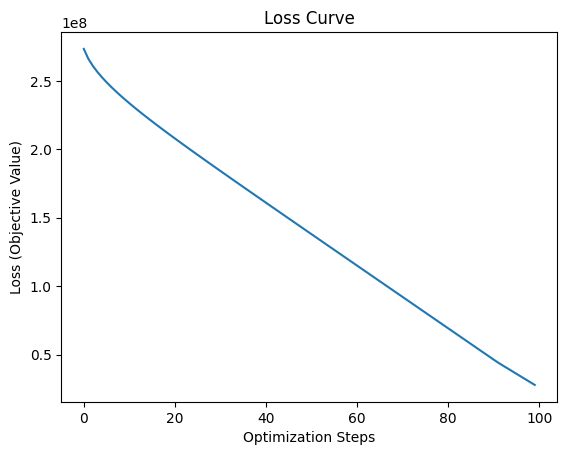

In [ ]:
# Final optimized values
optimized_num_vehicle_use = tf.round(num_vehicle_use).numpy()
optimized_num_vehicle_buy = tf.round(num_vehicle_buy).numpy()
optimized_num_vehicle_sell = tf.round(num_vehicle_sell).numpy()
print(f'Optimized number of vehicles for use: {optimized_num_vehicle_use}')
print(f'Optimized number of vehicles for buy: {optimized_num_vehicle_buy}')
print(f'Optimized number of vehicles for sell: {optimized_num_vehicle_sell}')

# Plotting the loss curve
plt.plot(value_history)
plt.xlabel('Optimization Steps')
plt.ylabel('Loss (Objective Value)')
plt.title('Loss Curve')
plt.show()

In [ ]:
# Initialize variables
id, year, num_vehicle_buy, num_vehicle_use, num_vehicle_sell, unit_fuel_consumption, yearly_range, unit_fuel_cost, purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct, num_vehicle_demand = inputCost(submission_df, vehicles_merge_fuel_df, demand_df)

# Choose an optimizer
optimizer = Ftrl(learning_rate=0.01)

# Optimization loop
coords_history = []
value_history7 = []

for step in range(100):  # Number of optimization steps
    with tf.GradientTape() as tape:
        loss = totalCost(num_vehicle_use, num_vehicle_buy, num_vehicle_sell, unit_fuel_consumption, yearly_range, unit_fuel_cost, purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct)

    grads = tape.gradient(loss, [num_vehicle_use, num_vehicle_buy, num_vehicle_sell])
    optimizer.apply_gradients(zip(grads, [num_vehicle_use, num_vehicle_buy, num_vehicle_sell]))

    # Apply projection to ensure non-negativity
    num_vehicle_use.assign(tf.nn.relu(num_vehicle_use))
    num_vehicle_buy.assign(tf.nn.relu(num_vehicle_buy))
    num_vehicle_sell.assign(tf.nn.relu(num_vehicle_sell))

    current_loss = loss.numpy()
    current_value = current_loss

    coords_history.append({
        'num_vehicle_use': tf.round(num_vehicle_use).numpy(),
        'num_vehicle_buy': tf.round(num_vehicle_buy).numpy(),
        'num_vehicle_sell': tf.round(num_vehicle_sell).numpy()
    })
    value_history7.append(current_value)

    if step % 10 == 0:
        print(f'Step {step}, Loss (objective value): {current_loss}, Objective Value: {current_value}')

Step 0, Loss (objective value): 273293472.0, Objective Value: 273293472.0
Step 10, Loss (objective value): 261797888.0, Objective Value: 261797888.0
Step 20, Loss (objective value): 255904832.0, Objective Value: 255904832.0
Step 30, Loss (objective value): 251349536.0, Objective Value: 251349536.0
Step 40, Loss (objective value): 247497856.0, Objective Value: 247497856.0
Step 50, Loss (objective value): 244099008.0, Objective Value: 244099008.0
Step 60, Loss (objective value): 241023024.0, Objective Value: 241023024.0
Step 70, Loss (objective value): 238192384.0, Objective Value: 238192384.0
Step 80, Loss (objective value): 235556352.0, Objective Value: 235556352.0
Step 90, Loss (objective value): 233079520.0, Objective Value: 233079520.0


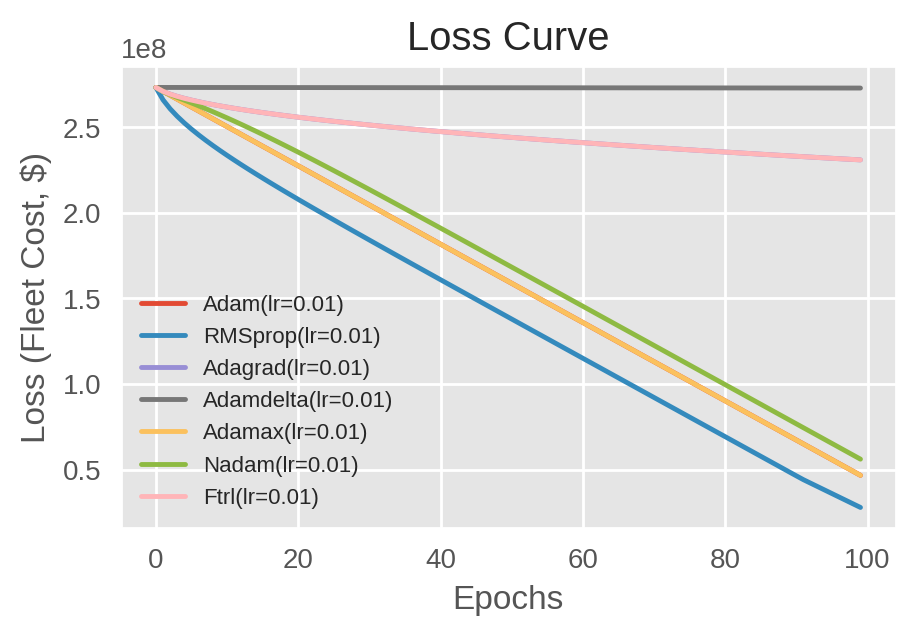

In [ ]:
# Plotting the loss curve
plt.figure(figsize=(5,3))
plt.plot(value_history, label='Adam(lr=0.01)')
plt.plot(value_history2, label='RMSprop(lr=0.01)')
plt.plot(value_history3, label='Adagrad(lr=0.01)')
plt.plot(value_history4, label='Adamdelta(lr=0.01)')
plt.plot(value_history5, label='Adamax(lr=0.01)')
plt.plot(value_history6, label='Nadam(lr=0.01)')
plt.plot(value_history7, label='Ftrl(lr=0.01)')


plt.xlabel('Epochs')
plt.ylabel('Loss (Fleet Cost, $)')
plt.title('Loss Curve')
plt.legend(fontsize=8)
plt.show()

### 6 - Optimization stage 2 (apply constraint 1: sell each year < 20% of vehicle fleet)

In [ ]:
def apply_constraints(num_vehicle_use, num_vehicle_buy, num_vehicle_sell, id, year):
    df = pd.DataFrame({
        'ID': id.numpy(),
        'Year': year.numpy(),
        'Use': num_vehicle_use.numpy(),
        'Buy': num_vehicle_buy.numpy(),
        'Sell': num_vehicle_sell.numpy()
    })

    grouped = df.groupby(['ID', 'Year']).sum().reset_index()

    for index, row in df.iterrows():
        total_use_buy = grouped[
            (grouped['ID'] == row['ID']) &
            (grouped['Year'] == row['Year'])
        ][['Use', 'Buy']].sum(axis=1).values[0]

        max_sell = 0.2 * total_use_buy
        if row['Sell'] > max_sell:
            df.at[index, 'Sell'] = max_sell
    df['Sell'] = tf.round(df['Sell'])  # Ensure values are rounded to nearest integer
    return tf.constant(df['Sell'].values, dtype=tf.float32)


In [ ]:
#
# run function
apply_constraints(num_vehicle_use, num_vehicle_buy, num_vehicle_sell, id, year)

<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7634332656860352' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell


<tf.Tensor: shape=(1687,), dtype=float32, numpy=array([1., 1., 1., ..., 0., 1., 1.], dtype=float32)>

In [ ]:
# Choose an optimizer
# optimizer = Adam(learning_rate=0.001)
optimizer = RMSprop(learning_rate=0.01)

# Optimization loop
coords_history = []
value_history = []

for step in range(100):  # Number of optimization steps
    with tf.GradientTape() as tape:
        loss = totalCost(num_vehicle_use, num_vehicle_buy, num_vehicle_sell,
                         unit_fuel_consumption, yearly_range, unit_fuel_cost,
                         purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct)

    grads = tape.gradient(loss, [num_vehicle_use, num_vehicle_buy, num_vehicle_sell])
    optimizer.apply_gradients(zip(grads, [num_vehicle_use, num_vehicle_buy, num_vehicle_sell]))

    # Apply constraints
    num_vehicle_sell.assign(apply_constraints(num_vehicle_use, num_vehicle_buy, num_vehicle_sell, id, year))

    # Apply projection to ensure non-negativity
    num_vehicle_use.assign(tf.nn.relu(num_vehicle_use))
    num_vehicle_buy.assign(tf.nn.relu(num_vehicle_buy))
    num_vehicle_sell.assign(tf.nn.relu(num_vehicle_sell))

    current_loss = loss.numpy()
    current_value = current_loss

    coords_history.append({
        'num_vehicle_use': tf.round(num_vehicle_use).numpy(),
        'num_vehicle_buy': tf.round(num_vehicle_buy).numpy(),
        'num_vehicle_sell': tf.round(num_vehicle_sell).numpy()
    })
    value_history.append(current_value)

    if step % 10 == 0:
        print(f'Step {step}, Loss (objective value): {current_loss}, Objective Value: {current_value}')

# Final optimized values
optimized_num_vehicle_use = tf.round(num_vehicle_use).numpy()
optimized_num_vehicle_buy = tf.round(num_vehicle_buy).numpy()
optimized_num_vehicle_sell = tf.round(num_vehicle_sell).numpy()
print(f'Optimized number of vehicles for use: {optimized_num_vehicle_use}')
print(f'Optimized number of vehicles for buy: {optimized_num_vehicle_buy}')
print(f'Optimized total number of vehicles: {optimized_num_vehicle_sell}')
print(f'Optimized Objective Value: {current_value}')

<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7254859447479248' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell


Step 0, Loss (objective value): 25872512.0, Objective Value: 25872512.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7232542514801026' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7185561180114747' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.013641870021820069' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and

Step 10, Loss (objective value): 128011816.0, Objective Value: 128011816.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6751084804534913' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.670657253265381' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.009109561145305634' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and 

Step 20, Loss (objective value): 123119816.0, Objective Value: 123119816.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.632278871536255' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6281345367431641' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.6240052700042725' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and wil

Step 30, Loss (objective value): 121591968.0, Objective Value: 121591968.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5913512229919434' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5873023986816407' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5832584381103516' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and wi

Step 40, Loss (objective value): 119380640.0, Objective Value: 119380640.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5510344982147217' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5470176696777344' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5430024623870849' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and wi

Step 50, Loss (objective value): 114912176.0, Objective Value: 114912176.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5109249114990234' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5069190502166748' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5029137611389161' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and wi

Step 60, Loss (objective value): 116143784.0, Objective Value: 116143784.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8708866119384766' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8668845176696778' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.008004720509052278' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and

Step 70, Loss (objective value): 116213952.0, Objective Value: 116213952.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8308732986450196' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8268725395202637' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.8228718757629395' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and wi

Step 80, Loss (objective value): 111568512.0, Objective Value: 111568512.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7908685684204102' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7868682861328126' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7828680992126466' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and wi

Step 90, Loss (objective value): 108103136.0, Objective Value: 108103136.0


<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7508669376373291' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7468668937683106' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7428668022155762' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-19-25976369f509>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and wi

Optimized number of vehicles for use: [0. 0. 0. ... 1. 0. 0.]
Optimized number of vehicles for buy: [ 1. 34. 32. ...  0.  0.  0.]
Optimized total number of vehicles: [0. 1. 1. ... 0. 1. 1.]
Optimized Objective Value: 106889952.0


Optimized number of vehicles for use: [0. 0. 0. ... 1. 0. 0.]
Optimized number of vehicles for buy: [ 1. 34. 32. ...  0.  0.  0.]
Optimized number of vehicles for sell: [0. 1. 1. ... 0. 1. 1.]


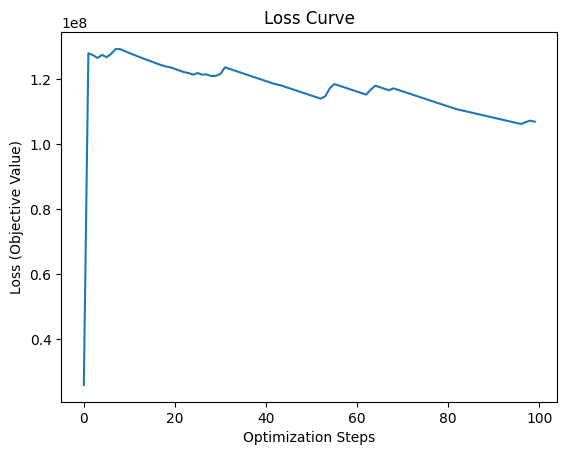

In [ ]:
# Final optimized values
optimized_num_vehicle_use = tf.round(num_vehicle_use).numpy()
optimized_num_vehicle_buy = tf.round(num_vehicle_buy).numpy()
optimized_num_vehicle_sell = tf.round(num_vehicle_sell).numpy()
print(f'Optimized number of vehicles for use: {optimized_num_vehicle_use}')
print(f'Optimized number of vehicles for buy: {optimized_num_vehicle_buy}')
print(f'Optimized number of vehicles for sell: {optimized_num_vehicle_sell}')

# Plotting the loss curve
plt.plot(value_history)
plt.xlabel('Optimization Steps')
plt.ylabel('Loss (Objective Value)')
plt.title('Loss Curve')
plt.show()

In [ ]:
def get_vehicle_info(row):
  """
  This function takes a row from the DataFrame and returns the number of vehicles
  and the type ("Buy", "Use", or "Sell") based on the non-zero value.

  Args:
      row (pd.Series): A row from the DataFrame.

  Returns:
      tuple: A tuple containing the number of vehicles (int) and the type (str).
  """

  # Check for non-zero values in Buy, Use, and Sell
  if row['Buy'] != 0:
    return row['Buy'], 'Buy'
  elif row['Use'] != 0:
    return row['Use'], 'Use'
  else:
    return row['Sell'], 'Sell'

In [ ]:
# Create dataframe from solution
ID = np.vectorize(lambda x: x.decode('utf-8'))(id.numpy())
Year = year.numpy()

df_solution = pd.DataFrame({'ID': ID, 'Year': Year, 'Buy': optimized_num_vehicle_buy,
              'Use': optimized_num_vehicle_use, 'Sell': optimized_num_vehicle_sell}).\
              astype({'Buy': 'int32', 'Use': 'int32', 'Sell': 'int32'})

df_solution[['Number vehicles', 'Type']] = df_solution.apply(get_vehicle_info, axis=1, result_type='expand')

df_solution

,ID,Year,Buy,Use,Sell,Number vehicles,Type
0,BEV_S1_2023,2023,1,0,0,1,Buy
1,Diesel_S1_2023,2023,34,0,1,34,Buy
2,LNG_S1_2023,2023,32,0,1,32,Buy
3,BEV_S2_2023,2023,2,0,1,2,Buy
4,Diesel_S2_2023,2023,13,0,1,13,Buy
...,...,...,...,...,...,...,...
1682,BEV_S3_2037,2038,0,2,1,2,Use
1683,BEV_S3_2038,2038,0,1,1,1,Use
1684,BEV_S3_2033,2038,0,1,0,1,Use
1685,BEV_S3_2036,2038,0,0,1,1,Sell


In [ ]:
submission_df[(submission_df.ID=='BEV_S3_2037') & (submission_df.Distance_bucket=='D3')]

,Year,ID,Num_Vehicles,Type,Fuel,Distance_bucket,Distance_per_vehicle(km)
1553,2037,BEV_S3_2037,4,Use,Electricity,D3,73000.0
1682,2038,BEV_S3_2037,4,Use,Electricity,D3,73000.0


### apply constraint demand

In [ ]:
# Define the function
def apply_constraints(num_vehicle_use, num_vehicle_buy, num_vehicle_sell, id, year, min_vehicle_demand):
    df = pd.DataFrame({
        'ID': id.numpy(),
        'Year': year.numpy(),
        'Use': num_vehicle_use.numpy(),
        'Buy': num_vehicle_buy.numpy(),
        'Sell': num_vehicle_sell.numpy(),
        'Demand': min_vehicle_demand.numpy()
    })

    grouped = df.groupby(['ID', 'Year']).sum().reset_index()

    for index, row in df.iterrows():
        total_use_buy = grouped[
            (grouped['ID'] == row['ID']) &
            (grouped['Year'] == row['Year'])
        ][['Use', 'Buy']].sum(axis=1).values[0]

        # Constraint 1: Sell < 0.2 * (Use + Buy)
        max_sell = 0.2 * total_use_buy
        if row['Sell'] > max_sell:
            df.at[index, 'Sell'] = max_sell

        # Constraint 2: Use >= Demand
        if row['Use'] < row['Demand']:
            df.at[index, 'Use'] = row['Demand']

    df['Sell'] = tf.round(df['Sell'])  # Ensure values are rounded to the nearest integer
    df['Buy'] = tf.round(df['Buy'])    # Ensure values are rounded to the nearest integer

    # Return the updated tensors
    return tf.constant(df['Use'].values, dtype=tf.float32), \
           tf.constant(df['Buy'].values, dtype=tf.float32), \
           tf.constant(df['Sell'].values, dtype=tf.float32)

In [ ]:
#
# run function
apply_constraints(num_vehicle_use, num_vehicle_buy, num_vehicle_sell, id, year, min_vehicle_demand)

<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.726866626739502' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell


(<tf.Tensor: shape=(1687,), dtype=float32, numpy=array([0., 0., 0., ..., 4., 4., 4.], dtype=float32)>,
 <tf.Tensor: shape=(1687,), dtype=float32, numpy=array([ 1., 34., 32., ...,  0.,  0.,  0.], dtype=float32)>,
 <tf.Tensor: shape=(1687,), dtype=float32, numpy=array([0., 1., 1., ..., 0., 1., 1.], dtype=float32)>)

In [ ]:
# Choose an optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Optimization loop
coords_history = []
value_history = []

for step in range(100):  # Number of optimization steps
    with tf.GradientTape() as tape:
        loss = totalCost(num_vehicle_use, num_vehicle_buy, num_vehicle_sell,
                         unit_fuel_consumption, yearly_range, unit_fuel_cost,
                         purchase_cost, resale_cost_pct, insurance_cost_pct, maintenance_cost_pct)

    grads = tape.gradient(loss, [num_vehicle_use, num_vehicle_buy, num_vehicle_sell])
    optimizer.apply_gradients(zip(grads, [num_vehicle_use, num_vehicle_buy, num_vehicle_sell]))

    # Apply constraints
    updated_use, updated_buy, updated_sell = apply_constraints(
        num_vehicle_use, num_vehicle_buy, num_vehicle_sell, id, year, min_vehicle_demand
    )

    # Reassign the updated values back to the variables
    num_vehicle_use.assign(updated_use)
    num_vehicle_buy.assign(updated_buy)
    num_vehicle_sell.assign(updated_sell)

    # Apply projection to ensure non-negativity
    num_vehicle_use.assign(tf.nn.relu(num_vehicle_use))
    num_vehicle_buy.assign(tf.nn.relu(num_vehicle_buy))
    num_vehicle_sell.assign(tf.nn.relu(num_vehicle_sell))

    current_loss = loss.numpy()
    current_value = current_loss

    coords_history.append({
        'num_vehicle_use': tf.round(num_vehicle_use).numpy(),
        'num_vehicle_buy': tf.round(num_vehicle_buy).numpy(),
        'num_vehicle_sell': tf.round(num_vehicle_sell).numpy()
    })
    value_history.append(current_value)

    if step % 10 == 0:
        print(f'Step {step}, Loss (objective value): {current_loss}, Objective Value: {current_value}')

# Final optimized values
optimized_num_vehicle_use = tf.round(num_vehicle_use).numpy()
optimized_num_vehicle_buy = tf.round(num_vehicle_buy).numpy()
optimized_num_vehicle_sell = tf.round(num_vehicle_sell).numpy()
print(f'Optimized number of vehicles for use: {optimized_num_vehicle_use}')
print(f'Optimized number of vehicles for buy: {optimized_num_vehicle_buy}')
print(f'Optimized total number of vehicles: {optimized_num_vehicle_sell}')
print(f'Optimized Objective Value: {current_value}')


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999946177005769' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell


Step 0, Loss (objective value): 106567872.0, Objective Value: 106567872.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999970763921739' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999922335147859' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999928295612335' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecat

Step 10, Loss (objective value): 1213503488.0, Objective Value: 1213503488.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.00799994021654129' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999943941831589' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999946922063827' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecate

Step 20, Loss (objective value): 1213503488.0, Objective Value: 1213503488.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.00799994468688965' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999947667121888' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.00799994468688965' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated

Step 30, Loss (objective value): 1213503488.0, Objective Value: 1213503488.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999946922063827' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999950647354126' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999949902296067' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecat

Step 40, Loss (objective value): 1213503488.0, Objective Value: 1213503488.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999950647354126' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999952137470246' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999952137470246' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecat

Step 50, Loss (objective value): 1213503488.0, Objective Value: 1213503488.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999947667121888' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999950647354126' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999947667121888' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecat

Step 60, Loss (objective value): 1213503488.0, Objective Value: 1213503488.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.003999973833560944' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999947667121888' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999947667121888' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecat

Step 70, Loss (objective value): 1213503488.0, Objective Value: 1213503488.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999949902296067' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999950647354126' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999947667121888' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecat

Step 80, Loss (objective value): 1213503488.0, Objective Value: 1213503488.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.0039999749511480335' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999950647354126' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999950647354126' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is depreca

Step 90, Loss (objective value): 1213503488.0, Objective Value: 1213503488.0


<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999949902296067' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999950647354126' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.007999950647354126' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[index, 'Sell'] = max_sell
<ipython-input-24-f0fade2f7d11>:23: FutureWarning: Setting an item of incompatible dtype is deprecat

Optimized number of vehicles for use: [0. 0. 0. ... 4. 4. 4.]
Optimized number of vehicles for buy: [ 1. 34. 32. ... -0. -0. -0.]
Optimized total number of vehicles: [0. 1. 1. ... 0. 1. 1.]
Optimized Objective Value: 1213503488.0


Optimized number of vehicles for use: [0. 0. 0. ... 4. 4. 4.]
Optimized number of vehicles for buy: [ 1. 34. 32. ... -0. -0. -0.]
Optimized number of vehicles for sell: [0. 1. 1. ... 0. 1. 1.]


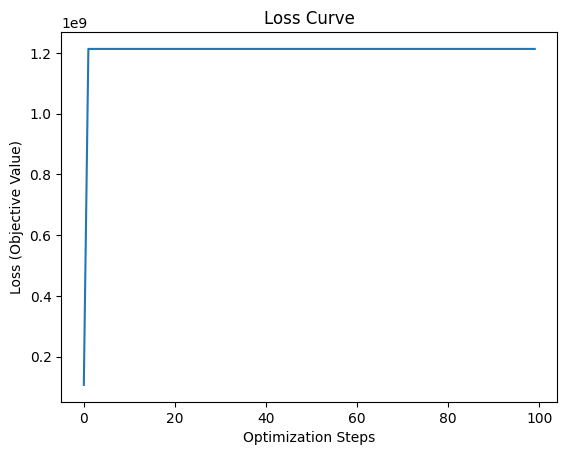

In [ ]:
# Final optimized values
optimized_num_vehicle_use = tf.round(num_vehicle_use).numpy()
optimized_num_vehicle_buy = tf.round(num_vehicle_buy).numpy()
optimized_num_vehicle_sell = tf.round(num_vehicle_sell).numpy()
print(f'Optimized number of vehicles for use: {optimized_num_vehicle_use}')
print(f'Optimized number of vehicles for buy: {optimized_num_vehicle_buy}')
print(f'Optimized number of vehicles for sell: {optimized_num_vehicle_sell}')

# Plotting the loss curve
plt.plot(value_history)
plt.xlabel('Optimization Steps')
plt.ylabel('Loss (Objective Value)')
plt.title('Loss Curve')
# plt.ylim(1.28e9, 1.3e9)
plt.show()